<a href="https://colab.research.google.com/github/claredavies/MachineLearningCoursework/blob/main/Assignment2/MachineLearningAssignment2SentimentAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Loading libaries and data

# Loading libraries and Data in

In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option("display.max_rows", None)

In [55]:
#uploading and reading RESTler output file with test cases
from google.colab import files
uploaded = files.upload()
dataset = pd.read_csv('Sentiment140.tenPercent.sample.tweets.tsv', sep='\t', delimiter=None, header='infer', names=None, index_col=None)

Saving Sentiment140.tenPercent.sample.tweets.tsv to Sentiment140.tenPercent.sample.tweets (2).tsv


# Data Exploration

Check Size of Data

In [56]:
print(dataset.head())
print(dataset.info())

   sentiment_label                                         tweet_text
0                4  @elephantbird Hey dear, Happy Friday to You  A...
1                4  Ughhh layin downnnn    Waiting for zeina to co...
2                0  @greeniebach I reckon he'll play, even if he's...
3                0              @vaLewee I know!  Saw it on the news!
4                0  very sad that http://www.fabchannel.com/ has c...
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 160000 entries, 0 to 159999
Data columns (total 2 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   sentiment_label  160000 non-null  int64 
 1   tweet_text       160000 non-null  object
dtypes: int64(1), object(1)
memory usage: 2.4+ MB
None


Check if any missing values

In [57]:
print(dataset.isnull().values.any())

False


In [58]:
df = dataset

print("Number of duplicates before dropping:  " + str(len(df[df.duplicated()])))


df.drop_duplicates(keep = False, inplace = True)
print("Number of duplicates after dropping:  " + str(len(df[df.duplicated()])))

Number of duplicates before dropping:  553
Number of duplicates after dropping:  0


Checking if data balanced

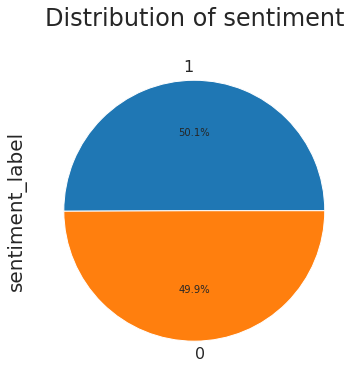

In [59]:
df['sentiment_label'] = df.sentiment_label.apply(lambda x: 1 if x == 4 else 0)

df['sentiment_label'].value_counts().plot.pie(figsize=(6,6),title="Distribution of sentiment",labels=['',''],autopct='%1.1f%%')
labels=["Positive","Negative"]
plt.legend(labels,loc=3)
plt.gca().set_aspect('equal')

# Data Pre-processing

In [40]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
nltk.download('punkt')
nltk.download('wordnet')

def clean(text):
    wn = nltk.WordNetLemmatizer()
    stopword = nltk.corpus.stopwords.words('english')
    tokens = nltk.word_tokenize(text)
    lower = [word.lower() for word in tokens]
    no_stopwords = [word for word in lower if word not in stopword]
    no_alpha = [word for word in no_stopwords if word.isalpha()]
    lemm_text = [wn.lemmatize(word) for word in no_alpha]
    clean_text = lemm_text
    return clean_text

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [60]:
print("Processing data...")
df['clean']=df['tweet_text'].map(clean)
df['clean_text']=df['clean'].apply(lambda x: " ".join([str(word) for word in x]))

Processing data...


In [61]:
print(df.head())

   sentiment_label  ...                                         clean_text
0                1  ...  elephantbird hey dear happy friday already ric...
1                1  ...   ughhh layin downnnn waiting zeina cook breakfast
2                0  ...  greeniebach reckon play even know nothing wo w...
3                0  ...                              valewee know saw news
4                0  ...          sad http closed one web service used year

[5 rows x 4 columns]


Creating word clouds...


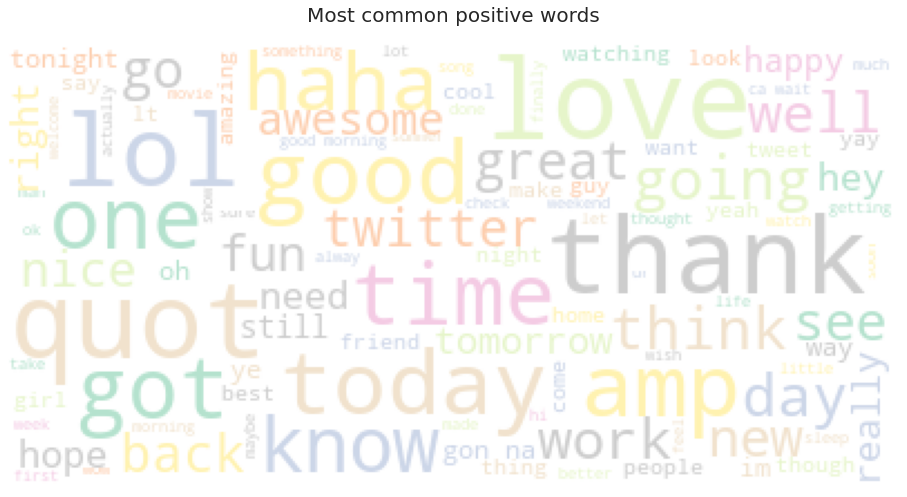

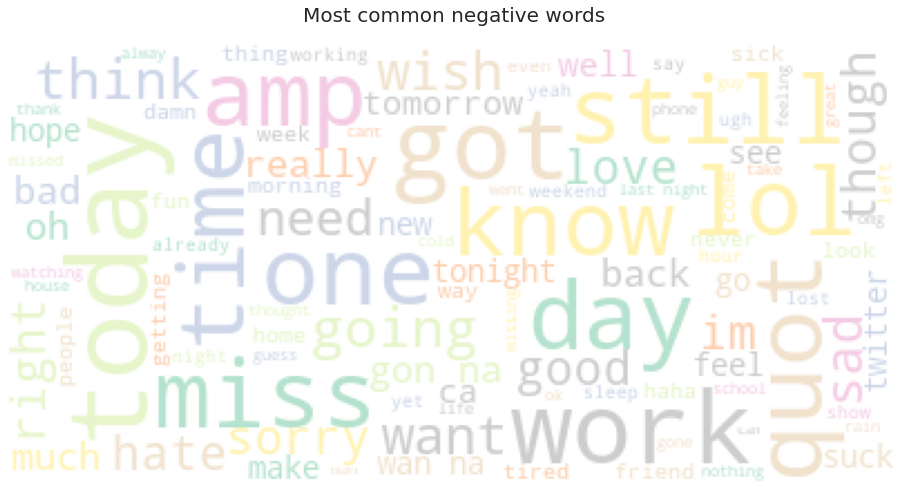

In [62]:
from wordcloud import WordCloud
from collections import Counter

def generate_wordcloud(words,sentiment):
    plt.figure(figsize=(16,13))
    wc = WordCloud(background_color="white", max_words=100, max_font_size=50)
    wc.generate(words)
    plt.title("Most common {} words".format(sentiment), fontsize=20)
    plt.imshow(wc.recolor(colormap='Pastel2', random_state=17), alpha=0.98)
    plt.axis('off')

print("Creating word clouds...")
positive_words=" ".join(df[df.sentiment_label==1]['clean_text'].values)
negative_words=" ".join(df[df.sentiment_label==0]['clean_text'].values)

generate_wordcloud(positive_words,"positive")
generate_wordcloud(negative_words,"negative")


In [63]:
from sklearn.feature_extraction.text import TfidfVectorizer

def vectorize(data,tfidf_vect_fit):
    X_tfidf = tfidf_vect_fit.transform(data)
    words = tfidf_vect_fit.get_feature_names()
    X_tfidf_df = pd.DataFrame(X_tfidf.toarray())
    X_tfidf_df.columns = words
    return(X_tfidf_df)

# Machine Learning

In [68]:
X = df['clean_text']   #Feature Matrix
y = df["sentiment_label"]          #Target Variable

In [69]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y , test_size=0.25, random_state=0)

In [67]:
tfidf_vect = TfidfVectorizer(analyzer=clean)
tfidf_vect_fit=tfidf_vect.fit(X_train['clean_text'])
X_train=vectorize(X_train['clean_text'],tfidf_vect_fit)

KeyError: ignored

In [ ]:
models = {}

# Logistic Regression
from sklearn.linear_model import LogisticRegression
models['Logistic Regression'] = LogisticRegression()

# Support Vector Machines
from sklearn.svm import LinearSVC
models['Support Vector Machines'] = LinearSVC()

# Decision Trees
from sklearn.tree import DecisionTreeClassifier
models['Decision Trees'] = DecisionTreeClassifier()

# Random Forest
from sklearn.ensemble import RandomForestClassifier
models['Random Forest'] = RandomForestClassifier()

# Naive Bayes
from sklearn.naive_bayes import GaussianNB
models['Naive Bayes'] = GaussianNB()

# K-Nearest Neighbors
from sklearn.neighbors import KNeighborsClassifier
models['K-Nearest Neighbor'] = KNeighborsClassifier()

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score

accuracy, precision, recall = {}, {}, {}

for key in models.keys():
    
    # Fit the classifier model
    models[key].fit(x_train, y_train)
    
    # Prediction 
    predictions = models[key].predict(x_test)
    
    # Calculate Accuracy, Precision and Recall Metrics
    accuracy[key] = accuracy_score(predictions, y_test)
    precision[key] = precision_score(predictions, y_test)
    recall[key] = recall_score(predictions, y_test)

In [ ]:
import pandas as pd

df_model = pd.DataFrame(index=models.keys(), columns=['Accuracy', 'Precision', 'Recall'])
df_model['Accuracy'] = accuracy.values()
df_model['Precision'] = precision.values()
df_model['Recall'] = recall.values()

df_model